# Exploring the basic functionalities of the Sequencer
This notebook will contain examples that show the basic functionalities of the Sequencer. The notebook starts with a simulation of a very simple dataset that contains a clear one-dimensional sequence. Then, I will show several examples of how to apply the Sequencer to this dataset and how to use its output and various derived parameters. In particular, the will show: <br>
1. **Basic Sequencer run:** application of the Sequencer, with default settings, to the dataset. I will show how to define the Sequencer object and how to execute the Sequencer. I will show how to extract the axis ratio and the resulting sequence, and how to visualize the ordered dataset. Then, I will show how to extract other properties of the algorithm, such as the estimators and scales, and intermediate axis ratios and sequences. <br>
2. **Basic Sequencer run with parallelization:** the Sequencer algorithm involves the calculation of a set of distance matrices for the different estimators and scales. For large datasets, this takes most of the computation time. In this example I will show how to estimate the distance matrices in parallel. <br>
2. **Non-default Sequencer setting:** application of the sequencer with non-default settings. I will show how to define the scale list, and how to change the print and output options of the sequencer. <br>
3. **Loading the distance matrix list from memory:** when applying the algorithm to the data, one can choose to save the calculated distance matrices per estimator and scale for future use. If the algorithm is used more than once for the same dataset, saving the calculated distance matrices and then loading them can save a lot of computation time. In this exmaple I will show how to load the distance matrix list into memory and avoid the time it takes to re-compute them (this becomes very important for large datasets!).

In [55]:
# imports
%matplotlib inline

import sys
sys.path.append("../code/")
import importlib

import sequencer
importlib.reload(sequencer)

import numpy
import matplotlib.pyplot as plt

## Simulate a very simple dataset
I will start by simulating a very simple dataset that consists of 1D objects with a single pulse. The dataset will contain 20 objects, each of length 20. Each object will be composed of zero continuum and a single pulse with a varying location. The locations of the pulses in the different objects will form a clear one-dimensional sequence. <br>
The final dataset will be a shuffled version of the simulated dataset.

In [56]:
# construct the grid and the objects_list

grid = numpy.arange(20)
objects_list_simulated = []
objects_true_indices = numpy.arange(20) # the ordered indices

for i in range(20):
    y = numpy.zeros(20)
    y[i] = 1
    objects_list_simulated.append(y)
objects_list_simulated = numpy.array(objects_list_simulated)
    
numpy.random.shuffle(objects_true_indices)
objects_list_shuffled = objects_list_simulated[objects_true_indices, :]

**Input data visualization:** the dataset consists of 20 one-dimensional objects. I can plot each of the objects separately using 1D lines, where the relative height of each 1D line represents its relative order within the dataset. Alternatively, I can plot all the objects together as a matrix, using 2D image. In the following cells, I visualize the dataset using both methods.

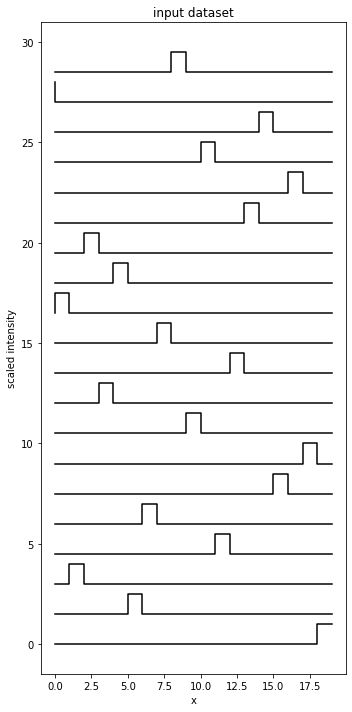

In [57]:
# visualize the input dataset as separate objects

plt.figure(1, figsize=(5, 10))
plt.title("input dataset")
for i, object_data in enumerate(objects_list_shuffled):
    object_data_scaled_y = object_data + i*1.5 # scale the objects so they will not be one on top of the other
    plt.step(grid, object_data_scaled_y, "k")
    
plt.xlabel("x")
plt.ylabel("scaled intensity")

plt.tight_layout()

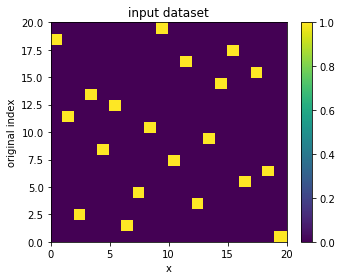

In [58]:
# visualize the input dataset 

plt.figure(1, figsize=(5, 4))
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

## 1. Basic Sequencer run
I will start by applying the Sequencer to this dataset using its default settings. In the first cell, I define the list of distance metrics to consider. I then define the Sequencer object and apply it to the dataset.

In [59]:
# define the list of distance metrics to consider.
# I don't include the KL-Divergence because the dataset contains zero values
estimator_list = ['EMD', 'energy', 'L2']

# define the sequencer object with default parameters
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)

# to execute the sequencer, we first need to define the output directory to which the different 
# outputs will be saved
output_path = "sequencer_output_directory"
final_axis_ratio, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.028462886810302734 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 0.020879030227661133 seconds
calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 0.0015752315521240234 seconds
dumped the distance matrix dictionaries to the file: sequencer_output_directory/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: EMD, scale: 1
in estimator: energy, scale: 1
in estimator: L2, scale: 1
dumped the axis ratios to the file: sequencer_output_directory/axis_ratios.pkl
dumped the full weighted distance matrix to the file: sequencer_output_directory/weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_

**Result:** The Sequencer was successfully applied to the dataset. I will now print the resulting axis ratio and sequence. The detected sequence vector represents the order in which the objects in the dataset should be ordered. <br>
After printing the axis raito and resulting sequence, I will reorder the objects in the dataset according to the detected sequence, and will plot the ordered dataset.

The MST axis ratio:  20.0
The resulting sequence:  [ 0  6 15  5 17 14  9  3 16  7 19 10  4  1 12  8 13  2 11 18]


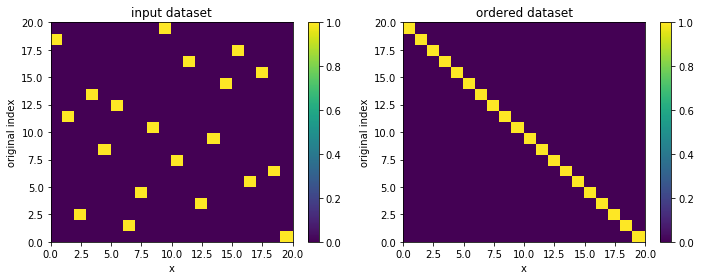

In [60]:
# print the final axis ratio
print("The MST axis ratio: ", final_axis_ratio)

# print the resulting sequence
print("The resulting sequence: ", final_sequence)

# order the input dataset according to the detected sequence
objects_list_ordered = objects_list_shuffled[final_sequence]

# visualize the ordered dataset
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 2, 2)
plt.title("ordered dataset")
plt.pcolormesh(objects_list_ordered)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

**Results:** The sequencer successfully identified the one-dimensional trend in pulse location, and we obtained an axis ratio of 20, which represents a perfect sequence. <br>

Now, I will print several additional properties of the algorithm: I will start by extracting and printing the distance metrics and scales that were used to estimate the final sequence. Then, I will show how to extract the intermediate axis ratios that were calculated during the run, where each intermediate axis ratio corresponds to a particular distance metric and scale. By examining the intermediate axis ratios, we can learn which metric and scale was the most useful.

In [61]:
# extract the distance metric list and scale list
estimator_list = seq.estimator_list # distance metrics
scale_list = seq.scale_list # scales
print(estimator_list)
print(scale_list)

# print them one by one
print("The metrics and scales used by the code:")
for estimator_index, estimator_name in enumerate(estimator_list):
    scale_list_of_estimator = scale_list[estimator_index]
    for scale_index, scale_name in enumerate(scale_list_of_estimator):
        print("I used metric %s with scale %s" % (estimator_name, scale_name))

['EMD', 'energy', 'L2']
[[1], [1], [1]]
The metrics and scales used by the code:
I used metric EMD with scale 1
I used metric energy with scale 1
I used metric L2 with scale 1


Now let's examine the intermediate axis ratios obtained for each estimator and scale. To do that, there are several different options: <br>
1. The first is using the function ```seq.return_axis_ratio_of_weighted_products(estimator_name, scale)```, which returns the intermediate axis ratio only for the given ```estimator_name``` and ```scale```. I will show this example first. <br> <br>
2. The second is using the function ```seq.return_axis_ratio_of_weighted_products_all_metrics_and_scales()```, which resturns a list of all estimators, scales, and their corresponding intermediate axis ratios. I will show this example sceond. 

In [63]:
# first example
estimator_name = 'EMD'
scale = 1
print("Intermediate axis ratio for metric=%s and scale=%s: %s" % (estimator_name, scale, 
                                                                  seq.return_axis_ratio_of_weighted_products(estimator_name, scale)))

# second example
estimator_list, scale_list, axis_ratio_list = seq.return_axis_ratio_of_weighted_products_all_metrics_and_scales()
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, axis ratio: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   axis_ratio_list[i]))

Intermediate axis ratio for metric=EMD and scale=1: 20.0
metric=EMD, scale=1, axis ratio: 20.0
metric=energy, scale=1, axis ratio: 20.0
metric=L2, scale=1, axis ratio: 2.5


**What do we see?** when using the EMD or the Energy Distance, we find a maximal axis ratio of 20, which represents a perfect sequence. On the other hand, when using the Euclidean Distance (L2), we find a very low axis ratio of 2.5. This is expected since the Euclidean distance is not sensitive to horizontal shifts in the data, and thus the distance between all the objects in the sample is similar. Therefore, using the Euclidean Distance, we cannot recover the one-dimensional trend. The EMD and Energy Distance are sensitive to horizontal shifts, and thus they can be used to detect the sequence. <br>

To illustrate this point further, let's extract the intermediate sequences for each estimator and scale, and plot the resulting ordering. There are two functions that can be used to extract the intemediate sequences, which are very similar to the functions that extract the intermediate axis ratios: <br>
1. The first is using the function ```seq.return_sequence_of_weighted_products(estimator_name, scale)```, which returns the intermediate sequence only for the given ```estimator_name``` and ```scale```. I will not show this example. <br> <br>
2. The second is using the function ```seq.return_sequence_of_weighted_products_all_metrics_and_scales()```, which resturns a list of all estimators, scales, and their corresponding intermediate sequences. I will show only this example. 

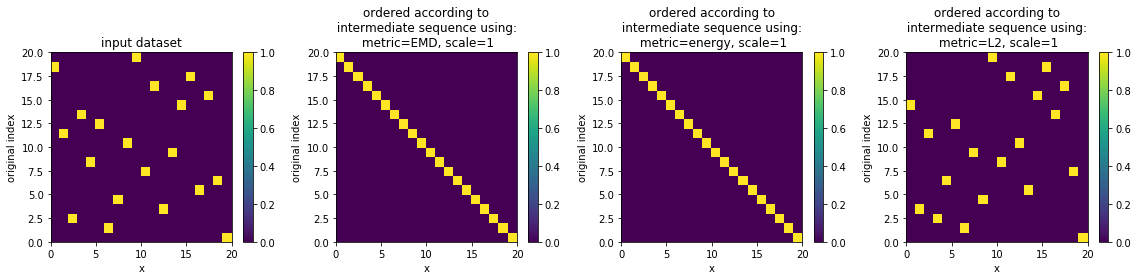

In [67]:
estimator_list, scale_list, sequence_list = seq.return_sequence_of_weighted_products_all_metrics_and_scales()

plt.figure(1, figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 4, 2)
plt.title("ordered according to\n intermediate sequence using: \n metric=%s, scale=%s" % (estimator_list[0], scale_list[0]))
sequnce = sequence_list[0]
plt.pcolormesh(objects_list_shuffled[sequnce])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 4, 3)
plt.title("ordered according to\n intermediate sequence using: \n metric=%s, scale=%s" % (estimator_list[1], scale_list[1]))
sequnce = sequence_list[1]
plt.pcolormesh(objects_list_shuffled[sequnce])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 4, 4)
plt.title("ordered according to\n intermediate sequence using: \n metric=%s, scale=%s" % (estimator_list[2], scale_list[2]))
sequnce = sequence_list[2]
plt.pcolormesh(objects_list_shuffled[sequnce])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

As expected, we find a perfect sequence using the EMD and the Energy distance, and no sequence using the Euclidean Distance.

## 2. Basic Sequencer run with parallelization
Now I will apply the Sequencer to the same dataset, still with default settings, but I will show how to apply parallelization. To use parallelization, we can use the option ```to_use_parallelization=True``` in the function ```seq.execute()```. <br>
Obviously, for this tiny dataset, this will not imporve the computation time of the algorithm. For large datasets, users are encoraged to use this option to improve the computation time!

In [68]:
estimator_list = ['EMD', 'energy', 'L2']
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)

output_path = "sequencer_output_directory"
final_axis_ratio, final_sequence = seq.execute(output_path, to_use_parallelization=True)

Parallelization is ON. Number of cores: 4
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 2.095259189605713 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 0.319598913192749 seconds
calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 0.09287190437316895 seconds
dumped the distance matrix dictionaries to the file: sequencer_output_directory/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: EMD, scale: 1
in estimator: energy, scale: 1
in estimator: L2, scale: 1
dumped the axis ratios to the file: sequencer_output_directory/axis_ratios.pkl
dumped the full weighted distance matrix to the file: sequencer_output_directory/weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer

../code/sequencer.py:938: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


The MST axis ratio:  20.0
The resulting sequence:  [ 0  6 15  5 17 14  9  3 16  7 19 10  4  1 12  8 13  2 11 18]


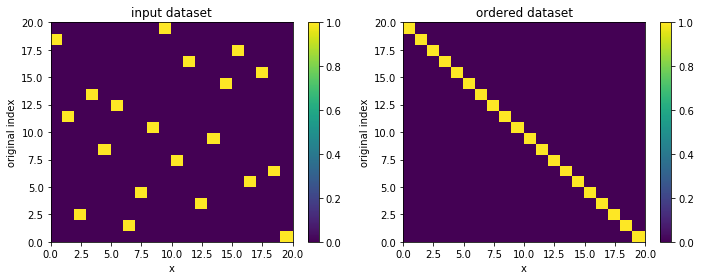

In [69]:
# print the final axis ratio
print("The MST axis ratio: ", final_axis_ratio)

# print the resulting sequence
print("The resulting sequence: ", final_sequence)

# order the input dataset according to the detected sequence
objects_list_ordered = objects_list_shuffled[final_sequence]

# visualize the ordered dataset
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 2, 2)
plt.title("ordered dataset")
plt.pcolormesh(objects_list_ordered)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()